In [2]:
#Load the model and dependencies
import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import pickle
import cv2, numpy as np
from deconv_utils import *
import copy

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
#Load the VGG Model and ImageNet Class Mappings
from library.classifiers.pretrained_vgg16 import PretrainedVGG
model = PretrainedVGG(h5_file = 'Data/vgg16_weights.h5')
CLASSES = pickle.load(open('Data/CLASSES.pkl'))

In [6]:
#Input Image File
filename = 'Images/dog.jpg'
#Layer from which the image will be segment
layer = 11
#No of neurons to evaluate from ranked list
kmax = 7

In [9]:
im = load_image_cv2(filename)
activs, caches = get_activs(model, im)
class_no = np.argmax(activs[15][0])
print class_no, CLASSES[class_no]
#print [CLASSES[i] for i in np.argsort(-activs[15][0])[:5]]
#print  np.argsort(-activs[15][0])[:5]

246 Great Dane


In [10]:
#Get Actives & Cache -Blob
# Set Class no if you want to force localize
#class_no=264
print CLASSES[class_no]
#Get Backgrad Up until the layer of choice
#This is used to rank the neurons to obtain best blobs
back_grad = get_backgrad(activs, model, class_no, layer, caches)

#Get the Filters of Interest in Sorted Order
amax = filter_of_intr(activs,back_grad,kmax,layer)
filter_scores = get_filter_scores(
    amax, model, im, activs,caches, layer, class_no,
    percentile_thresh=40,use_blob=True)

Great Dane
15
(1, 4096)
(4096, 1000)
(1, 4096)
(4096, 4096)
(1, 25088)
(25088, 4096)
410 (5, 8)
0 0 0 0
score = 9.89132
170 (4, 8)
0 0 0 0
score = 9.85718
398 (4, 8)
0 0 0 0
score = 10.2468
281 (4, 7)
0 0 0 0
score = 9.81703
48 (4, 8)
0 0 0 0
score = 10.2186
270 (4, 8)
0 0 0 0
score = 9.72672
81 (4, 8)
0 0 0 0
score = 10.0491


10.0491


(-0.5, 223.5, 223.5, -0.5)

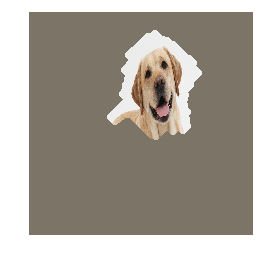

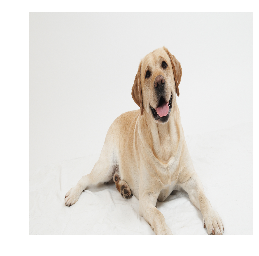

In [11]:
#Union Blobs
sorted_scores = sorted(filter_scores,key=lambda x:-x[1])
mask = np.zeros(im.shape)
for k in range(3):
    i,n_score,blob,xmin,xmax,ymin,ymax=sorted_scores[k]
    mask = (mask+blob)>0
newim = im.copy()*mask
#plt.imshow(newim[0].transpose(1,2,0))
plot_image_cv2(newim.copy())
plt.axis("off")
print n_score
plt.figure()
plot_image_cv2(im)
plt.axis("off")

246 Great Dane
15
(1, 4096)
(4096, 1000)
(1, 4096)
(4096, 4096)
(1, 25088)
(25088, 4096)
410 (5, 8)
0 0 0 0
score = 15.2504
170 (4, 8)
0 0 0 0
score = 14.5609
398 (4, 8)
0 0 0 0
score = 15.0093
281 (4, 7)
0 0 0 0
score = 14.4986
48 (4, 8)
0 0 0 0
score = 14.5609
270 (4, 8)
0 0 0 0
score = 15.0093
81 (4, 8)
0 0 0 0
score = 14.5609
15.2504


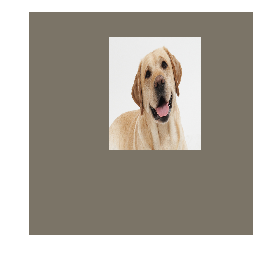

In [12]:
#Get Actives & Cache - no Blob
im = load_image_cv2(filename)
activs, caches = get_activs(model, im)
#class_no = np.argmax(activs[15][0])
print class_no, CLASSES[class_no]
#class_no=341
#Get Backgrad Up until the layer of choice
#This is used to rank the neurons to obtain best blobs
back_grad = get_backgrad(activs, model,class_no, layer, caches)

#Get the Filters of Interest in Sorted Order
amax = filter_of_intr(activs,back_grad,kmax,layer)
filter_scores = get_filter_scores(
    amax, model, im, activs,caches, layer, class_no,
    percentile_thresh=80,use_blob=False)


#Union Blobs
mask = np.zeros(im.shape)
for k in range(1):
    i,n_score,blob,xmin,xmax,ymin,ymax=sorted(filter_scores,key=lambda x:-x[1])[k]
    mask = (mask+blob)>0
newim = im.copy()*mask
#plt.imshow(newim[0].transpose(1,2,0))
plot_image_cv2(newim)
plt.axis("off")
print n_score

(-0.5, 223.5, 223.5, -0.5)

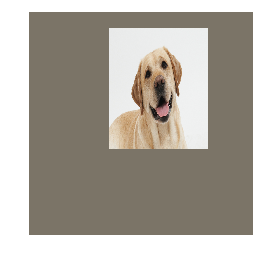

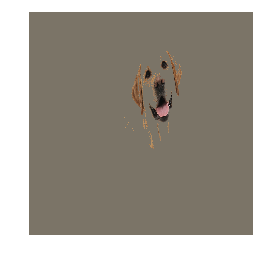

In [13]:
#GrabCut version of UnionBlob
im2 = im[0].transpose(1,2,0).astype('uint8')
im3 = load_image_cv2(filename)
ymin = xmin= 100000
ymax = xmax= -100000
for k in range(5):
    i,n_score,blob,xmin2,xmax2,ymin2,ymax2=sorted(filter_scores,key=lambda x:-x[1])[k]
    xmin = min(xmin,xmin2)
    ymin = min(ymin,ymin2)
    ymax = max(ymax,ymax2)
    xmax = max(xmax,xmax2)

bmask = np.zeros(im.shape)
bmask[0,:,xmin:xmax,ymin:ymax]=1
plot_image_cv2(im*bmask)
plt.axis("off")
mask = grabCut(im2,xmin,xmax,ymin,ymax)>0
mask2 = np.zeros(im3.shape)
mask2[:,0,:,:]= mask2[:,1,:,:]= mask2[:,2,:,:]= mask
newim = im3.copy()*mask2

#plt.imshow(newim[0].transpose(1,2,0))
# im3 = cv2.cvtColor(newim, cv2.cv.CV_BGR2RGB)
# plt.imshow(im3)
plt.figure()
plot_image_cv2(newim)
#plt.imshow(mask)
plt.axis("off")